In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import seaborn as sns
from stimuli import staircase

In [58]:
def phi_j_t(X, j, t, t_val, tau_val):
    '''
    evoked potential for neuron j at time t
    '''
    cumulative_time_array = np.arange(0, tt + 1) / 1000.
    phi = np.dot(np.exp(-(t_val - cumulative_time_array) / tau_val), X[j, :tt + 1])
    return phi

def phi_t(X, t, t_val, tau_val):
    '''
    summed evoked potentials across all neurons at time t
    '''
    cumulative_time_array = np.arange(0, t + 1) / 1000.
    phi = np.dot(np.exp(-(t_val - cumulative_time_array) / tau_val), X[:, :t + 1].transpose())
    return phi


def eta_i_t(X, i, t, t_val, tau_val, eta_0):
    '''
    adaptation potential of neuron i at time t
    '''
    cumulative_time_array = np.arange(0, tt + 1) / 1000.
    phi = np.dot(np.exp(-(t_val - cumulative_time_array) / tau_val), X[i, :tt + 1])
    return -eta_0 * phi


def rho_i_t(u, i, t, v, delta_u):
    '''
    firing rate of neuron i at time t
    '''
    return rho_0 * np.exp(u[i, t] - v / delta_u)


def log_likelihood(X, u, neuron_start_idx=0):
    '''
    compute log likelihood of current model
    '''
    likelihoods = []
    for ii in range(neuron_start_idx, num_neurons):
        
        for tt in range(num_timebins):
            
            curr_rho = rho_i_t(u=u, v=v, delta_u=delta_u, i=ii, t=tt)
            curr_x = X[ii, tt]
            
            curr_likelihood = np.log(curr_rho) * curr_x - curr_rho
            likelihoods.append(curr_likelihood)
            
    return np.sum(likelihoods)

def visible_weight_gradient(X, i, j, tau_val, t, u):
    ## loop over time bins
    timebin_summands = []
    for tt in range(num_timebins):

        tt_val = tt / 1000.

        curr_phi_j_t = phi_j_t(X=data, j=j, t=t, t_val=tt_val, tau_val=tau_val)

        x_minus_rho = data[i, t] - rho_i_t(u=u, v=v, t=t, i=ii, delta_u=delta_u)

        summand = curr_phi_j_t * x_minus_rho
        timebin_summands.append(summand)

    weight_gradient = np.sum(timebin_summands)
    return weight_gradient

def update_membrane_potential(X, t, tau_val1, tau_val2, weights):
    
    tt_val = t / 1000.
    
    cumulative_time_array = np.arange(0, tt + 1) / 1000.
    phi_unscaled = phi_t(X=X, t=t, t_val=tt_val, tau_val=tau_val1)
    phi = np.dot(weights[ii, :], phi_unscaled)

    eta = eta_i_t(X=X, tau_val=tau_val2, t=t, t_val=tt_val, i=ii, eta_0=eta_0)
    
    return phi + eta


In [75]:
num_visible_neurons = 9
num_hidden_neurons = 9
num_neurons = num_visible_neurons + num_hidden_neurons
num_timebins = 300
num_iter = 100
print_iter = 10

tau = 0.01
eta_0 = 0.1
tau_adapt = 0.01
rho_0 = 1
v = 0
delta_u = 1
mu_M = 1e-6
mu_Q = 1e-8
tau_G = 0.01
tau_baseline = 0.1
dt = 0.001

## Generate synthetic data
data = np.random.binomial(n = 1, p = 0.1, size = [num_neurons, num_timebins])
true_weights = np.random.normal(loc=0, scale=0.1, size = [num_neurons, num_neurons]) # not used currently, but one could do a simulation to see if the true weights are recovered




In [76]:
M_weights = np.random.normal(loc=0, scale=0.01, size = [num_neurons, num_neurons])
Q_weights = np.random.normal(loc=0, scale=0.01, size = [num_neurons, num_neurons])

# no connections hidden->visible or visible->viisble
# index [i, j] is weight from j to i (following paper's lead on this)
Q_weights[:num_visible_neurons, :] = np.nan

M_potentials = np.zeros((num_neurons, num_timebins))
Q_potentials = np.zeros((num_neurons, num_timebins))

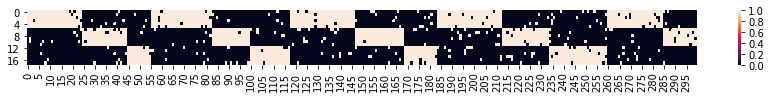

In [77]:
data = staircase(num_neurons=num_neurons, num_timebins=num_timebins)

fig, ax = plt.subplots(figsize=(15,1))  
sns.heatmap(data)

In [93]:
likelihood_trace_M = []
likelihood_trace_Q = []
M_potential_trace = []
M_weight_trace = []
free_energy_trace = []
for iter_num in range(num_iter):
    
    ### UPDATE MEMBRANE POTENTIALS
    
    ## Update membrane potential for M-network
    for ii in range(num_neurons):
        
        # loop over time bins
        for tt in range(num_timebins):
            
#             potential_update = update_membrane_potential(X=data, t=tt, tau_val1=tau, tau_val2=tau_adapt, weights=M_weights)

#             M_potentials[ii, tt] = potential_update
            
            tt_val = tt / 1000.
            
            ## loop over neurons
            cumulative_time_array = np.arange(0, tt + 1) / 1000.
            phi_unscaled = phi_t(X=data, t=tt, t_val=tt_val, tau_val=tau)
            phi = np.dot(M_weights[ii, :], phi_unscaled)
            
            eta = eta_i_t(X=data, tau_val=tau_adapt, t=tt, t_val=tt_val, i=ii, eta_0=eta_0)
            M_potentials[ii, tt] = phi + eta
            
#     M_potential_trace.append(M_potentials)
            
    # Update membrane potential for Q-network
    for ii in range(num_visible_neurons, num_neurons):
                
        for tt in range(num_timebins):
            
#             potential_update = update_membrane_potential(X=data, t=tt, tau_val1=tau, tau_val2=tau_adapt, weights=Q_weights)

#             Q_potentials[ii, tt] = potential_update


            #####
            
            tt_val = tt / 1000.
            
            ## loop over neurons
            cumulative_time_array = np.arange(0, tt + 1) / 1000.
            phi_unscaled = phi_t(X=data, t=tt, t_val=tt_val, tau_val=tau)
            phi = np.dot(Q_weights[ii, :], phi_unscaled)
            
            eta = eta_i_t(X=data, tau_val=tau_adapt, t=tt, t_val=tt_val, i=ii, eta_0=eta_0)
            Q_potentials[ii, tt] = phi + eta
            
            #####
            
            
    ### UPDATE SYNAPTIC WEIGHTS
    
    # Update weights for M-network
    for ii in range(num_neurons):
        for jj in range(num_neurons):
            
#             M_weight_gradient = visible_weight_gradient(X=data, i=ii, j=jj, tau_val=tau, t=tt, u=M_potentials)
#             M_weights[ii, jj] += mu_M * M_weight_gradient

            #####
            
            timebin_summands = []
            for tt in range(num_timebins):
                
                tt_val = tt / 1000.
                
                curr_phi_j_t = phi_j_t(X=data, j=jj, t=tt, t_val=tt_val, tau_val=tau)
                                
                x_minus_rho = data[ii, tt] - rho_i_t(u=M_potentials, v=v, t=tt, i=ii, delta_u=delta_u)
        
                summand = curr_phi_j_t * x_minus_rho
                timebin_summands.append(summand)
                
            M_weight_gradient = np.sum(timebin_summands)
            M_weights[ii, jj] += mu_M * M_weight_gradient
            
            #####
            
#     M_weight_trace.append(M_weights)
            
    
    # Update weights for Q-network
    
    if iter_num == 0:
        free_energy_stabilizer = 2000
    else:
        free_energy_stabilizer = np.mean(free_energy_trace)
    
    for ii in range(num_visible_neurons, num_neurons):
        for jj in range(num_neurons):
            
#             Q_weight_gradient_without_free_energy = visible_weight_gradient(X=data, i=ii, j=jj, tau_val=tau, t=tt, u=Q_potentials)

            #####
            
            timebin_summands = []
            for tt in range(num_timebins):
                
                tt_val = tt / 1000.
                
                curr_phi_j_t = phi_j_t(X=data, j=jj, t=tt, t_val=tt_val, tau_val=tau)
                                
                x_minus_rho = data[ii, tt] - rho_i_t(u=Q_potentials, v=v, t=tt, i=ii, delta_u=delta_u)
        
                summand = curr_phi_j_t * x_minus_rho
                timebin_summands.append(summand)
                
            Q_weight_gradient_without_free_energy = np.sum(timebin_summands)
            
            #####
            
            # calculate free energy
            M_likelihood = log_likelihood(X=data, u=M_potentials)
            Q_likelihood = log_likelihood(X=data, u=Q_potentials, neuron_start_idx=num_visible_neurons)
            free_energy = Q_likelihood - M_likelihood
            free_energy_trace.append(free_energy)
            
            # final gradient
            if iter_num == 0:
                weight_gradient = 0
            else:
                weight_gradient = (free_energy - free_energy_stabilizer) * Q_weight_gradient_without_free_energy

            # update
            Q_weights[ii, jj] += -mu_Q * weight_gradient
            
    curr_likelihood_M = log_likelihood(u=M_potentials, X=data)
    likelihood_trace_M.append(curr_likelihood_M)
    
    curr_likelihood_Q = log_likelihood(u=Q_potentials, X=data)
    likelihood_trace_Q.append(curr_likelihood_Q)
    print 'M: {}, Q: {}'.format(curr_likelihood_M, curr_likelihood_Q)
    
    


M: -3374.20554712, Q: -4143.73907349
M: -3369.90583265, Q: -4143.73907349
M: -3365.66689555, Q: -4143.68348513
M: -3361.48761144, Q: -4143.60165248
M: -3357.36688404, Q: -4143.49423815
M: -3353.30364414, Q: -4143.36199599
M: -3349.29684869, Q: -4143.20569436
M: -3345.34547985, Q: -4143.0261025
M: -3341.44854418, Q: -4142.82398589
M: -3337.60507175, Q: -4142.60010386
M: -3333.81411542, Q: -4142.35520808
M: -3330.07475004, Q: -4142.09004138
M: -3326.38607176, Q: -4141.80533683
M: -3322.74719732, Q: -4141.5018169
M: -3319.15726338, Q: -4141.1801928
M: -3315.61542594, Q: -4140.84116382
M: -3312.12085968, Q: -4140.48541689
M: -3308.67275742, Q: -4140.11362604
M: -3305.27032955, Q: -4139.72645208
M: -3301.9128035, Q: -4139.32454221
M: -3298.59942322, Q: -4138.90852981
M: -3295.32944873, Q: -4138.47903416
M: -3292.1021556, Q: -4138.03666032
M: -3288.91683454, Q: -4137.58199896
M: -3285.77279094, Q: -4137.11562628
M: -3282.66934449, Q: -4136.63810399
M: -3279.60582874, Q: -4136.14997924
M: -32

Text(0,0.5,'log-likelihood')

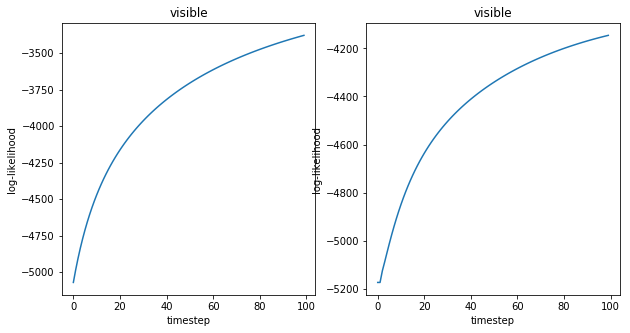

In [84]:
fig, ax = plt.subplots(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(likelihood_trace_M)
plt.xlabel("timestep")
plt.title("visible")
plt.ylabel("log-likelihood")
plt.subplot(1, 2, 2)
plt.plot(likelihood_trace_Q)
plt.xlabel("timestep")
plt.title("visible")
plt.ylabel("log-likelihood")

In [85]:
## Generate data from learned weights

simulated_potentials_visible = np.zeros((num_neurons, num_timebins))
    
## Simulate membrane potential
for ii in range(num_neurons):

    # loop over time bins
    for tt in range(num_timebins):

        tt_val = tt / 1000.

        ## loop over neurons
        potential_list = []
        for jj in range(num_neurons):

            curr_weight = M_weights[ii, jj] * phi_j_t(X=data, j=jj, t=tt, t_val=tt_val, tau_val=tau)
            potential_list.append(curr_weight)

        simulated_potentials_visible[ii, tt] = np.sum(potential_list) + eta_i_t(X=data, tau_val=tau_adapt, t=tt, t_val=tt_val, i=ii, eta_0=eta_0)

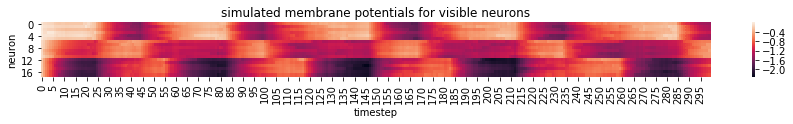

In [86]:
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap(simulated_potentials_visible)
plt.xlabel("timestep")
plt.ylabel("neuron")
plt.title("simulated membrane potentials for visible neurons")
plt.show()

In [87]:
## Generate data from learned weights

simulated_potentials_hidden = np.zeros((num_hidden_neurons, num_timebins))
    
## Simulate membrane potential
for ii in range(num_visible_neurons, num_neurons):

    # loop over time bins
    for tt in range(num_timebins):

        tt_val = tt / 1000.

        ## loop over neurons
        potential_list = []
        for jj in range(num_neurons):

            curr_weight = Q_weights[ii, jj] * phi_j_t(X=data, j=jj, t=tt, t_val=tt_val, tau_val=tau)
            potential_list.append(curr_weight)

        simulated_potentials_hidden[ii - num_visible_neurons, tt] = np.sum(potential_list) + eta_i_t(X=data, tau_val=tau_adapt, t=tt, t_val=tt_val, i=ii, eta_0=eta_0)

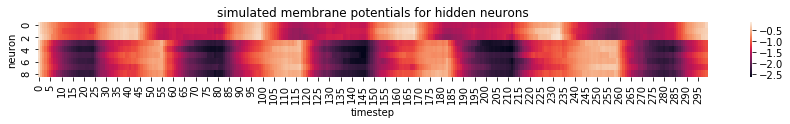

In [88]:
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap(simulated_potentials_hidden)
plt.xlabel("timestep")
plt.ylabel("neuron")
plt.title("simulated membrane potentials for hidden neurons")
plt.show()

In [89]:
poisson_rates = np.zeros((num_neurons, num_timebins))
for ii in range(num_neurons):
    for tt in range(num_timebins):
        poisson_rates[ii, tt] = rho_i_t(delta_u=delta_u, i=ii, t=tt, u=simulated_potentials_visible, v=v)


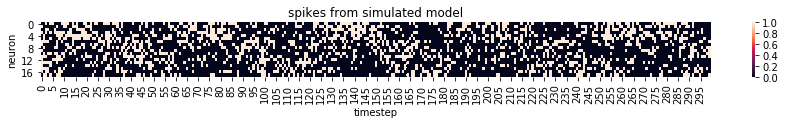

In [90]:
simulated_spikes = np.random.poisson(lam=poisson_rates)
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap((simulated_spikes >= 1).astype(int))
plt.xlabel("timestep")
plt.ylabel("neuron")
plt.title("spikes from simulated model")
plt.show()
plt.show()

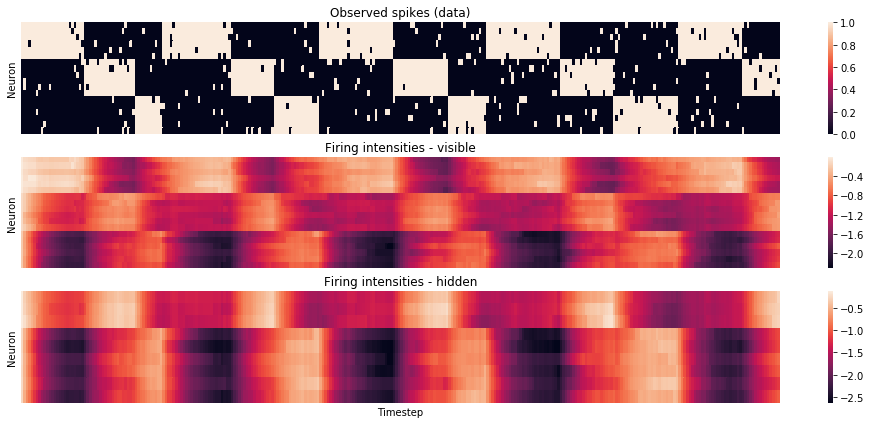

In [92]:
fig, ax = plt.subplots(figsize=(17,7))
plt.subplot(3, 1, 1)
sns.heatmap(data, xticklabels=False, yticklabels=False)
plt.title("Observed spikes (data)")
plt.ylabel("Neuron")
plt.subplot(3, 1, 2)
sns.heatmap(simulated_potentials_visible, xticklabels=False, yticklabels=False)
plt.title("Firing intensities - visible")
plt.ylabel("Neuron")
plt.subplot(3, 1, 3)
sns.heatmap(simulated_potentials_hidden, xticklabels=False, yticklabels=False)
plt.title("Firing intensities - hidden")
plt.xlabel("Timestep")
plt.ylabel("Neuron")
plt.savefig("/Users/aj13/Desktop/variational_spiking_networks/plots/hidden_and_visible_intensities.png")
plt.show()